In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/ieee-fraud-detection/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.simplefilter('ignore')

from sklearn import set_config
set_config(transform_output="pandas")

## 1. Data Loading and test/train split

Load the datasets and merge them.

In [3]:
df_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
df = pd.merge(df_transaction,df_identity,how="left",on="TransactionID")
print(f'Dimensions of the combined data set: {df.shape}')

del df_transaction, df_identity

Dimensions of the combined data set: (590540, 434)


Split the dataset into training and testing sets. The chosen test size is 20% of the total dataset.

In [4]:
from sklearn.model_selection import train_test_split

X = df.drop('isFraud', axis=1)
y = df['isFraud']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Dimensions of the train dataset is {X_train.shape} and {y_train.shape}')
print(f'Dimensions of the validation dataset is {X_valid.shape} and {y_valid.shape}')

del X, y

Dimensions of the train dataset is (472432, 433) and (472432,)
Dimensions of the validation dataset is (118108, 433) and (118108,)


## 2. Dagshub and MLflow

In [5]:
!pip install dagshub 
!pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.5 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      Successfully uninstalled dacite-1.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 25.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 88.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━

In [6]:
import dagshub
dagshub.init(repo_owner='zhorzholianimate', repo_name='IEEE-CIS-Fraud-Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=1b147e93-3e29-4537-a835-f30e074f9c8e&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=0cb70cefc8cf27458655019dc893eb73056df0958d0bf290a6df1b241a45a437




Accessing as zhorzholianimate

Initialized MLflow to track repo "zhorzholianimate/IEEE-CIS-Fraud-Detection"

Repository zhorzholianimate/IEEE-CIS-Fraud-Detection initialized!

In [7]:
import mlflow
mlflow.set_experiment("Basic_XGboost_training")

<Experiment: artifact_location='mlflow-artifacts:/fab003b08ec047b9b9e0a56a96beeb9e', creation_time=1745522354343, experiment_id='1', last_update_time=1745522354343, lifecycle_stage='active', name='Basic_XGboost_training', tags={}>

## 3. Cleaning and Feature Engineering

For now, we will use the same preprocess pipeline that was used in the logistic regression experiment, as this experiment is primarily about gaining an understanding of XGBoost and its specific hyperparameters.

Use the same transformer class to drop features with high missing values.

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropHighNaNColumns(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.8):
        self.threshold = threshold
        self.cols_to_drop = []

    def fit(self, X, y=None):
        missing_ratio = pd.DataFrame(X).isnull().mean()
        self.cols_to_drop = missing_ratio[missing_ratio > self.threshold].index.tolist()
        return self

    def transform(self, X):
        return pd.DataFrame(X).drop(columns=self.cols_to_drop)

We will use Costume Encoder which works as follows: if number of different elements is small it uses one hot encoding, else it uses woe encoding.

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.woe_columns = []
        self.one_hot_columns = []
        self.threshold = threshold
    def fit(self, X, y):
        cat_cols = [col for col in X.columns if X[col].dtype == 'object']
        s = X[cat_cols].nunique()
        self.woe_columns = list(s[s > self.threshold].index)
        self.one_hot_columns = list(s[s <= self.threshold].index)
        self.woe_columns_fill_na = X[self.woe_columns].mode().T[0].to_dict()
        df_woe = X.copy()
        target_col = 'target'
        df_woe[target_col] = y
        woe_mappings = {}
        iv_values = {}
        for col in self.woe_columns:
            groups = df_woe.groupby([col])[target_col].agg(['count', 'sum'])
            groups.columns = ['n_obs', 'n_pos']
            groups['n_neg'] = groups['n_obs'] - groups['n_pos']
            groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
            groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()
            groups['woe'] = np.log(groups['prop_pos'] / groups['prop_neg'])
            groups['iv'] = (groups['prop_pos'] - groups['prop_neg']) * groups['woe']
            groups.replace([np.inf, -np.inf], 0, inplace=True)
            groups.fillna(0, inplace=True)
            woe_dict = groups['woe'].to_dict()
            iv = groups['iv'].sum()
            woe_mappings[col] = woe_dict
            iv_values[col] = iv
        self.woe_mappings = woe_mappings
        self.iv_values = iv_values
        return self


    def transform(self, X):
        X_transformed = X.copy()
        for col in self.woe_columns:
            X_transformed[f'woe_{col}'] = X_transformed[col].map(self.woe_mappings[col])
            X_transformed.drop(columns=col, inplace=True)
        X_transformed = pd.get_dummies(X_transformed, columns=self.one_hot_columns, drop_first=True, dummy_na=True, dtype=int)
        n = X_transformed.isna().mean()
        na_cols = list(n[n > 0].index)
        for col in na_cols:
            pr, name = col.split("_", 1)
            if pr != "woe":
                print("Error Related to Nans")
                continue
            dic = self.woe_columns_fill_na
            mappings = self.woe_mappings
            X_transformed[col] = X_transformed[col].fillna(mappings[name][dic[name]])
            
        return X_transformed

Also, we will use same features filtered by RFE in the logistic regresion experiment.

In [10]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        return X[self.columns]

Now, lets build pipeline.

In [11]:
# columns filtered by RFE
columns = ['num__TransactionID', 'num__TransactionAmt', 'num__card3', 'num__C1',
       'num__C2', 'num__C3', 'num__C7', 'num__C9', 'num__C11', 'num__C13',
       'num__C14', 'num__D2', 'num__D3', 'num__D5', 'num__D11', 'num__V6',
       'num__V13', 'num__V17', 'num__V18', 'num__V19', 'num__V21', 'num__V25',
       'num__V33', 'num__V35', 'num__V36', 'num__V44', 'num__V45', 'num__V47',
       'num__V48', 'num__V50', 'num__V54', 'num__V56', 'num__V59', 'num__V62',
       'num__V67', 'num__V70', 'num__V71', 'num__V73', 'num__V82', 'num__V83',
       'num__V87', 'num__V94', 'num__V135', 'num__V170', 'num__V172',
       'num__V174', 'num__V183', 'num__V190', 'num__V191', 'num__V197',
       'num__V199', 'num__V200', 'num__V204', 'num__V205', 'num__V207',
       'num__V221', 'num__V222', 'num__V223', 'num__V228', 'num__V236',
       'num__V242', 'num__V248', 'num__V252', 'num__V253', 'num__V257',
       'num__V258', 'num__V261', 'num__V262', 'num__V264', 'num__V267',
       'num__V268', 'num__V269', 'num__V271', 'num__V274', 'num__V281',
       'num__V283', 'num__V284', 'num__V296', 'num__V311', 'num__V312',
       'num__id_01', 'num__id_02', 'num__id_17', 'woe_cat__ProductCD',
       'woe_cat__card4', 'woe_cat__card6', 'woe_cat__P_emaildomain',
       'woe_cat__R_emaildomain', 'woe_cat__id_31', 'woe_cat__DeviceInfo',
       'cat__M3_T', 'cat__M5_T', 'cat__M5_unknown', 'cat__M6_T',
       'cat__M6_unknown', 'cat__id_12_NotFound', 'cat__id_16_unknown',
       'cat__id_29_NotFound', 'cat__id_35_T', 'cat__id_37_T']

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector

imputer = ColumnTransformer(transformers=[
            ('num', SimpleImputer(strategy="median"), make_column_selector(dtype_include=np.number)),
            ('cat', SimpleImputer(strategy="constant", fill_value='unknown'), make_column_selector(dtype_include=object))
        ])
cleaner = Pipeline([
    ('highNA', DropHighNaNColumns()),
    ('imputer', imputer),
    ('encoder', CategoricalEncoder()),
    ('scaler', StandardScaler()),
])

In [13]:
preprocess = Pipeline([
    ('cleaner', cleaner),
    ('selector', ColumnSelector(columns=columns)),
    ])

We will fit our dataset to the given pipeline.

In [14]:
X_t = preprocess.fit_transform(X_train, y_train)
X_t

,num__TransactionID,num__TransactionAmt,num__card3,num__C1,num__C2,num__C3,num__C7,num__C9,num__C11,num__C13,...,cat__M3_T,cat__M5_T,cat__M5_unknown,cat__M6_T,cat__M6_unknown,cat__id_12_NotFound,cat__id_16_unknown,cat__id_29_NotFound,cat__id_35_T,cat__id_37_T
5307,-1.700744,-0.322223,-0.281587,-0.090256,-0.091973,-0.036011,-0.045973,-0.208847,-0.097695,-0.243633,...,1.161145,2.117912,-1.207619,1.434901,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
191582,-0.608256,-0.473144,2.808078,-0.097725,-0.091973,-0.036011,-0.029813,-0.268883,-0.097695,-0.243633,...,-0.861219,-0.472163,0.828076,-0.696912,1.576344,1.949576,-1.889161,2.814915,-0.389051,2.085434
260168,-0.206005,-0.419880,-0.281587,-0.060379,-0.066138,-0.036011,-0.045973,-0.088777,-0.065949,-0.112188,...,-0.861219,-0.472163,0.828076,-0.696912,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
18516,-1.623274,-0.148516,-0.281587,-0.097725,-0.091973,-0.036011,-0.045973,-0.268883,-0.087113,-0.235901,...,-0.861219,-0.472163,0.828076,-0.696912,1.576344,-0.512932,-1.889161,-0.355251,2.570359,2.085434
47538,-1.453063,-0.254435,-0.281587,-0.097725,-0.091973,-0.036011,-0.045973,-0.268883,-0.097695,-0.243633,...,-0.861219,-0.472163,0.828076,-0.696912,1.576344,1.949576,-1.889161,-0.355251,2.570359,2.085434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,-1.085156,-0.466272,5.014982,-0.090256,-0.091973,-0.036011,-0.045973,-0.268883,-0.097695,-0.251365,...,-0.861219,-0.472163,0.828076,-0.696912,1.576344,-0.512932,-1.889161,-0.355251,2.570359,2.085434
259178,-0.211811,0.944352,-0.281587,-0.097725,-0.091973,-0.036011,-0.045973,-0.268883,-0.097695,-0.243633,...,-0.861219,-0.472163,0.828076,-0.696912,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
365838,0.413741,0.088741,-0.281587,-0.060379,-0.072597,-0.036011,-0.045973,-0.148812,-0.087113,-0.034867,...,1.161145,-0.472163,-1.207619,1.434901,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
131932,-0.958099,-0.322223,-0.281587,-0.097725,-0.091973,-0.036011,-0.045973,-0.088777,-0.076531,-0.197240,...,-0.861219,2.117912,-1.207619,-0.696912,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517


In [15]:
X_v = preprocess.transform(X_valid)
X_v

,num__TransactionID,num__TransactionAmt,num__card3,num__C1,num__C2,num__C3,num__C7,num__C9,num__C11,num__C13,...,cat__M3_T,cat__M5_T,cat__M5_unknown,cat__M6_T,cat__M6_unknown,cat__id_12_NotFound,cat__id_16_unknown,cat__id_29_NotFound,cat__id_35_T,cat__id_37_T
470624,1.028302,2.495212,-0.281587,-0.082786,-0.091973,-0.036011,-0.045973,-0.148812,-0.097695,-0.235901,...,-0.861219,-0.472163,-1.207619,1.434901,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
565820,1.586619,-0.112504,-0.281587,-0.090256,-0.091973,-0.036011,-0.045973,-0.208847,-0.097695,-0.197240,...,1.161145,-0.472163,-1.207619,1.434901,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
284083,-0.065745,-0.369039,-0.281587,-0.097725,-0.091973,-0.036011,-0.045973,-0.208847,-0.097695,-0.228169,...,1.161145,-0.472163,0.828076,-0.696912,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
239689,-0.326113,-0.145979,2.808078,-0.090256,-0.079055,-0.036011,-0.029813,-0.268883,-0.097695,-0.251365,...,-0.861219,-0.472163,0.828076,-0.696912,1.576344,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
281855,-0.078813,-0.114834,-0.281587,-0.030502,-0.008010,-0.036011,-0.045973,0.091330,-0.002456,0.081113,...,-0.861219,-0.472163,0.828076,1.434901,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373780,0.460320,-0.093439,-0.281587,-0.082786,-0.091973,-0.036011,-0.045973,-0.208847,-0.087113,-0.243633,...,-0.861219,-0.472163,-1.207619,-0.696912,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
245203,-0.293773,-0.076492,-0.281587,-0.097725,-0.091973,-0.036011,-0.045973,-0.208847,-0.097695,-0.181776,...,1.161145,-0.472163,-1.207619,-0.696912,-0.634379,-0.512932,0.529335,-0.355251,-0.389051,-0.479517
450760,0.911802,-0.320049,2.808078,-0.097725,-0.072597,-0.036011,-0.029813,-0.268883,-0.087113,-0.243633,...,-0.861219,-0.472163,0.828076,-0.696912,1.576344,1.949576,-1.889161,-0.355251,-0.389051,2.085434
529422,1.373148,-0.480762,2.808078,-0.097725,-0.085514,-0.036011,-0.013653,-0.268883,-0.097695,-0.235901,...,-0.861219,-0.472163,0.828076,-0.696912,1.576344,1.949576,-1.889161,-0.355251,-0.389051,2.085434


Log the results of this dataset in MLflow.

<Figure size 1200x600 with 0 Axes>

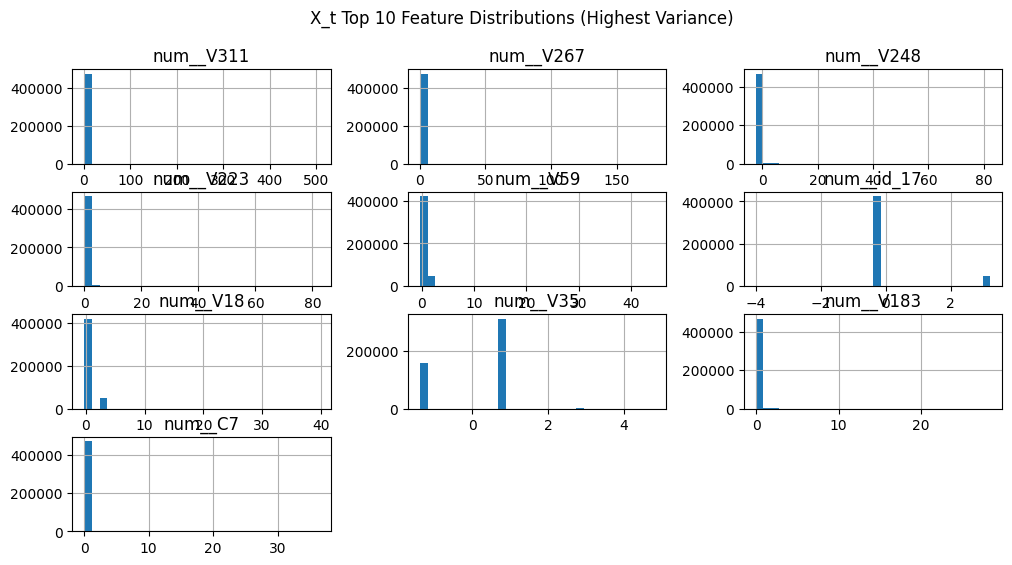

<Figure size 1200x600 with 0 Axes>

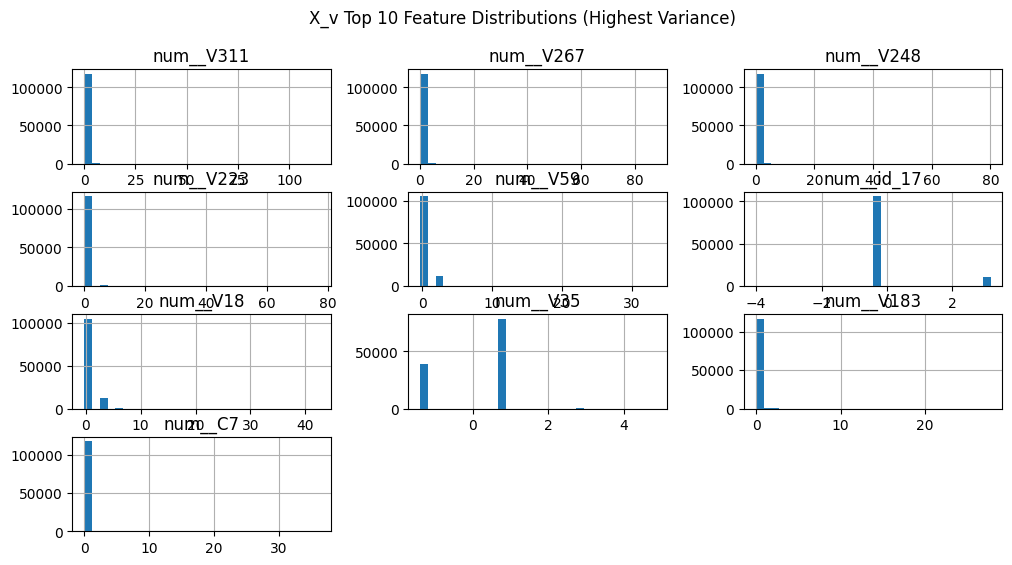

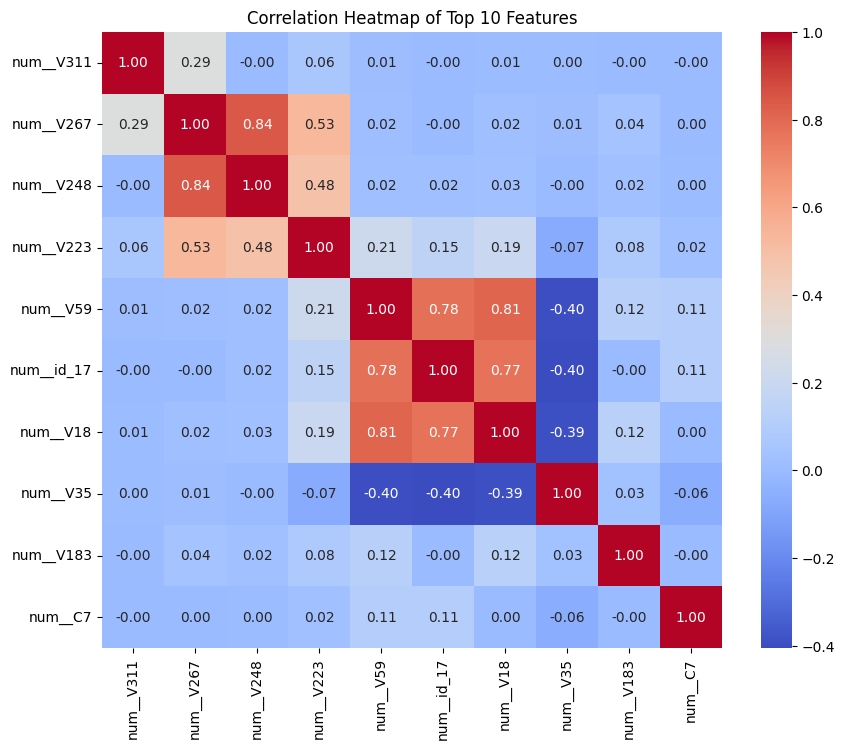

🏃 View run XGboost_Cleaning at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/6c6daf95bbb94ab69917e50573cdc885
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [16]:
with mlflow.start_run(run_name="XGboost_Cleaning"):

    mlflow.log_param("drop_high_na_threshold", 0.8)  
    mlflow.log_param("imputer_strategy_numerical", "mean")  
    mlflow.log_param("imputer_strategy_categorical", "constant")  
    mlflow.log_param("imputer_fill_value", "Uknown")
    mlflow.log_param("categorical_encoding", "onehot/woe") 
    mlflow.log_param("categorical_threshold", 3)  
    mlflow.log_param("categorical_handle_unknown", "ignore") 
    mlflow.log_param("categorical_drop", "first")  
    mlflow.log_param("categorical_sparse_output", True) 
    mlflow.log_param("rfe_n_features_to_select", 100) 
    mlflow.log_param("rfe_step", 0.1) 
    
    train_data_summary = pd.DataFrame(X_t).describe().T
    train_data_summary.to_csv("train_data_summary.csv", index=True)
    mlflow.log_artifact("train_data_summary.csv")
    
    valid_data_summary = pd.DataFrame(X_v).describe().T
    valid_data_summary.to_csv("valid_data_summary.csv", index=True)
    mlflow.log_artifact("valid_data_summary.csv") 

    columns_df = pd.DataFrame(columns, columns=["selected_column"]) 
    columns_df.to_csv("selected_columns.csv", index=False)
    mlflow.log_artifact("selected_columns.csv")
    del columns_df

    feature_variances = X_t.var()
    top_features = feature_variances.nlargest(10).index 
    plt.figure(figsize=(12, 6))
    X_t[top_features].hist(bins=30, figsize=(12, 6))
    plt.suptitle("X_t Top 10 Feature Distributions (Highest Variance)")
    plt.savefig("train_data_top_features_histograms.png")
    mlflow.log_artifact("train_data_top_features_histograms.png")
    plt.show()
    plt.close()
    
    plt.figure(figsize=(12, 6))
    X_v[top_features].hist(bins=30, figsize=(12, 6))
    plt.suptitle("X_v Top 10 Feature Distributions (Highest Variance)")
    plt.savefig("valid_data_top_features_histograms.png")
    mlflow.log_artifact("valid_data_top_features_histograms.png")
    plt.show()
    plt.close()
    
    corr_matrix = pd.DataFrame(X_t[top_features]).corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, xticklabels=top_features, yticklabels=top_features)
    plt.title("Correlation Heatmap of Top 10 Features")
    plt.savefig("correlation_heatmap.png")
    mlflow.log_artifact("correlation_heatmap.png")
    plt.show()
    plt.close()

## 4. Model Selection.

Now, let's see how XGboost performes in general.

In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb = XGBClassifier(n_jobs = -1, eval_metric="auc")
xgb.fit(X_t, y_train)

y_predict = xgb.predict_proba(X_v)[:, 1]
roc_auc = roc_auc_score(y_valid, y_predict)
print(roc_auc)

0.9274630169644555


As we can see, it performs well and quickly. Let's now tune the hyperparameters to find the best model. We will group the hyperparameters logically: first, we will tune the tree parameters, then the boosting parameters.

**Stage 1**: Tune the max_depth and min_child_weight parameters.

In [18]:
from sklearn.model_selection import GridSearchCV

param_grid_stage1 = {
    'max_depth': [3, 6, 10],              
    'min_child_weight': [1, 3, 5]             
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_stage1, cv=3, scoring='roc_auc', n_jobs=-1, verbose = 1)
grid_search.fit(X_t, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 10],
                         'min_child_weight': [1, 3, 5]},
             scoring='roc_auc', verbose=1)

In [19]:
print("Best parameters found: ", grid_search.best_params_)
xg = grid_search.best_estimator_
y_predict = xg.predict_proba(X_v)[:, 1]
roc_auc = roc_auc_score(y_valid, y_predict)
print(f'roc_auc: {roc_auc}')
print(f"booster: {xg.get_params()['booster']} and n_estimators: {xg.get_params()['n_estimators']}")

Best parameters found:  {'max_depth': 10, 'min_child_weight': 1}
roc_auc: 0.9487406909879834
booster: None and n_estimators: None


**Stage 2**: Tune the booster and n_estiamtors parameters.

In [20]:
param_grid_stage2 = {
    'booster': ['gbtree', 'gblinear'],   
    'n_estimators': [None, 50, 100]           
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid_stage2, cv=3, scoring='roc_auc', n_jobs=-1, verbose = 1)
grid_search.fit(X_t, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=-1, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'n_estimators': [None, 50, 100]},
             scoring='roc_auc', verbose=1)

In [21]:
print("Best parameters found: ", grid_search.best_params_)
xg = grid_search.best_estimator_
y_predict = xg.predict_proba(X_v)[:, 1]
roc_auc = roc_auc_score(y_valid, y_predict)
print(roc_auc)

Best parameters found:  {'booster': 'gbtree', 'n_estimators': None}
0.9274630169644555


The results above show that using the default values for booster and n_estimators yields the best model.

In [22]:
xgb = XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=10, min_child_weight=1)

Log this pipeline to the MLflow.

In [23]:
pipeline = Pipeline([
        ('preprocess', preprocess),
        ('model', xgb),
    ])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('cleaner',
                                  Pipeline(steps=[('highNA',
                                                   DropHighNaNColumns()),
                                                  ('imputer',
                                                   ColumnTransformer(transformers=[('num',
                                                                                    SimpleImputer(strategy='median'),
                                                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7a5d7277b5d0>),
                                                                                   ('cat',
                                                                                    SimpleImputer(fill_value='unknown',
                                                                                                  strategy='constant'),
                                                                                    <sklearn.compose....
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=None, ...))])

2025/04/26 09:35:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


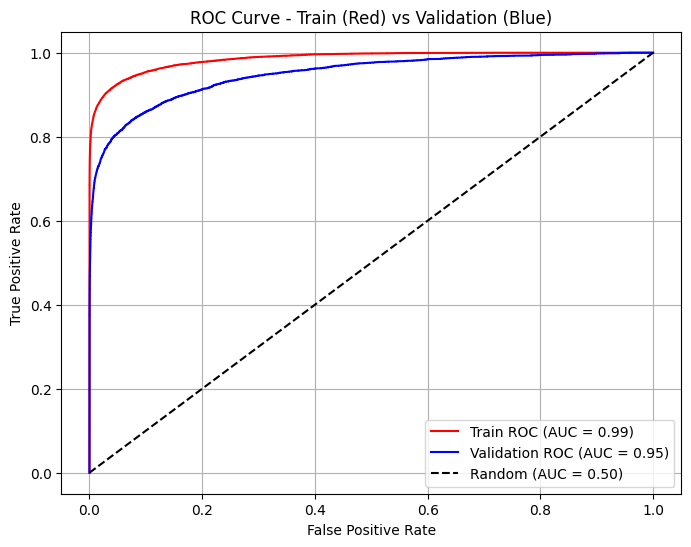

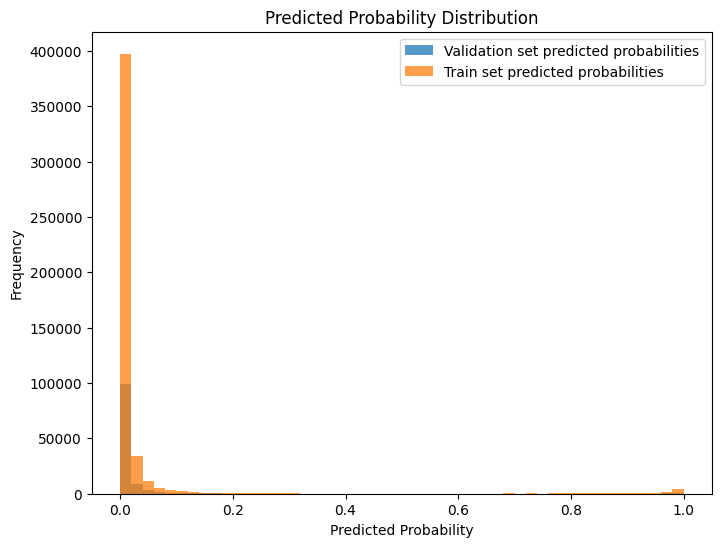

🏃 View run XGboost_Model at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/92c49de5254e4149a943231b92c85ff6
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

with mlflow.start_run(run_name='XGboost_Model'):

    mlflow.sklearn.log_model(pipeline, "xgboost_model")

    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
    y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
    auc_train = auc(fpr_train, tpr_train)
    auc_valid = auc(fpr_valid, tpr_valid)

    mlflow.log_metric("train_auc", auc_train)
    mlflow.log_metric("valid_auc", auc_valid)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='red', label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_valid, tpr_valid, color='blue', label=f'Validation ROC (AUC = {auc_valid:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train (Red) vs Validation (Blue)')
    plt.legend(loc='lower right')
    plt.grid(True)
    roc_image_path = "roc_curve.png"
    plt.savefig(roc_image_path)
    mlflow.log_artifact(roc_image_path)
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.hist(y_valid_proba, bins=50, alpha=0.75, label="Validation set predicted probabilities")
    plt.hist(y_train_proba, bins=50, alpha=0.75, label="Train set predicted probabilities")
    plt.title("Predicted Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    prob_dist_image_path = "probability_distribution.png"
    plt.savefig(prob_dist_image_path)
    mlflow.log_artifact(prob_dist_image_path)
    plt.show()
    plt.close()

    mlflow.log_param("preprocess_steps", [name for name, _ in preprocess.steps])
    mlflow.log_param("drop_high_nan", "enabled")
    mlflow.log_param("drop_high_nan_threashold", "0.8")
    num_imputer = imputer.named_transformers_['num']
    mlflow.log_param("num_imputer_strategy", num_imputer.strategy)
    cat_imputer = imputer.named_transformers_['cat']
    mlflow.log_param("cat_imputer_strategy", cat_imputer.strategy)
    mlflow.log_param("cat_imputer_fill_value", cat_imputer.fill_value)
    mlflow.log_param("categorical_encoder", "CategoricalEncoder()")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("rfe_steps", "0.1")
    mlflow.log_param("rfe_features_left", "100")

This might lead to overfitting; hence, it would be beneficial to set reg_alpha.

In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

max_depths = [10, 25, 40]
min_child_weights = [1, 3, 10]
reg_alphas = [5, 10, 50]
best_reg_alpha = 0
best_roc_auc = 0
best_max_depth = 0
best_min_child_weight = 0

for max_depth in max_depths:
    for min_child_weight in min_child_weights:
        for reg_alpha in reg_alphas:
            print(f'processing: max_depth:{max_depth}, min_child_weight:{min_child_weight}, reg_alpha={reg_alpha}', end=' ')
            xgb = XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=max_depth, min_child_weight=min_child_weight, reg_alpha=reg_alpha)
            xgb.fit(X_t, y_train)
            y_predict = xgb.predict_proba(X_v)[:, 1]
            roc_auc = roc_auc_score(y_valid, y_predict)
            print(f'and roc_auc={roc_auc}')
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc
                best_max_depth = max_depth
                best_min_child_weight = min_child_weight
                best_reg_alpha = reg_alpha

print(f"auc:{best_roc_auc}, max_depth:{best_max_depth}, min_child_weight:{best_min_child_weight}, reg_alpha:{best_reg_alpha}")

processing: max_depth:10, min_child_weight:1, reg_alpha=5 and roc_auc=0.950665562264214
processing: max_depth:10, min_child_weight:1, reg_alpha=10 and roc_auc=0.9465646259568132
processing: max_depth:10, min_child_weight:1, reg_alpha=50 and roc_auc=0.9228608483798666
processing: max_depth:10, min_child_weight:3, reg_alpha=5 and roc_auc=0.9460248341655191
processing: max_depth:10, min_child_weight:3, reg_alpha=10 and roc_auc=0.9451562937909274
processing: max_depth:10, min_child_weight:3, reg_alpha=50 and roc_auc=0.9233535985991059
processing: max_depth:10, min_child_weight:10, reg_alpha=5 and roc_auc=0.942908080544612
processing: max_depth:10, min_child_weight:10, reg_alpha=10 and roc_auc=0.9405001263592689
processing: max_depth:10, min_child_weight:10, reg_alpha=50 and roc_auc=0.9224583833219908
processing: max_depth:25, min_child_weight:1, reg_alpha=5 and roc_auc=0.9525610020208457
processing: max_depth:25, min_child_weight:1, reg_alpha=10 and roc_auc=0.9517370178117752
processing: m

In [26]:
pipeline = Pipeline([
        ('preprocess', preprocess),
        ('model', XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=25, min_child_weight=1, reg_alpha=5)),
    ])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('cleaner',
                                  Pipeline(steps=[('highNA',
                                                   DropHighNaNColumns()),
                                                  ('imputer',
                                                   ColumnTransformer(transformers=[('num',
                                                                                    SimpleImputer(strategy='median'),
                                                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7a5d7277b5d0>),
                                                                                   ('cat',
                                                                                    SimpleImputer(fill_value='unknown',
                                                                                                  strategy='constant'),
                                                                                    <sklearn.compose....
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=25, max_leaves=None,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=None, ...))])

2025/04/26 09:48:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


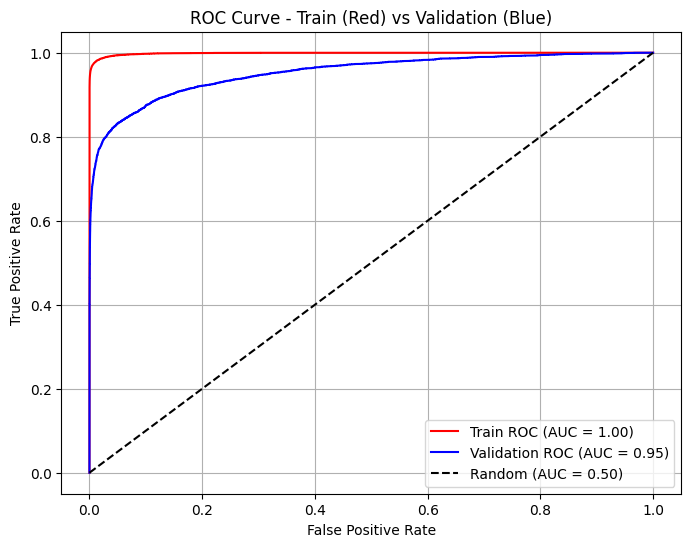

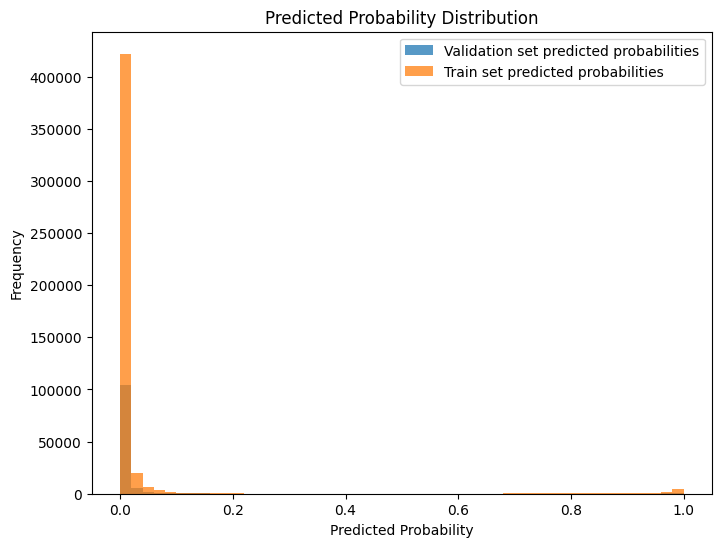

🏃 View run XGboost_Model_Alpha at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/665f6a2450c445fdb902e8339cf14283
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

with mlflow.start_run(run_name='XGboost_Model_Alpha'):

    mlflow.sklearn.log_model(pipeline, "xgboost_model")

    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
    y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
    auc_train = auc(fpr_train, tpr_train)
    auc_valid = auc(fpr_valid, tpr_valid)

    mlflow.log_metric("train_auc", auc_train)
    mlflow.log_metric("valid_auc", auc_valid)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='red', label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_valid, tpr_valid, color='blue', label=f'Validation ROC (AUC = {auc_valid:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train (Red) vs Validation (Blue)')
    plt.legend(loc='lower right')
    plt.grid(True)
    roc_image_path = "roc_curve.png"
    plt.savefig(roc_image_path)
    mlflow.log_artifact(roc_image_path)
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.hist(y_valid_proba, bins=50, alpha=0.75, label="Validation set predicted probabilities")
    plt.hist(y_train_proba, bins=50, alpha=0.75, label="Train set predicted probabilities")
    plt.title("Predicted Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    prob_dist_image_path = "probability_distribution.png"
    plt.savefig(prob_dist_image_path)
    mlflow.log_artifact(prob_dist_image_path)
    plt.show()
    plt.close()

    mlflow.log_param("preprocess_steps", [name for name, _ in preprocess.steps])
    mlflow.log_param("drop_high_nan", "enabled")
    mlflow.log_param("drop_high_nan_threashold", "0.8")
    num_imputer = imputer.named_transformers_['num']
    mlflow.log_param("num_imputer_strategy", num_imputer.strategy)
    cat_imputer = imputer.named_transformers_['cat']
    mlflow.log_param("cat_imputer_strategy", cat_imputer.strategy)
    mlflow.log_param("cat_imputer_fill_value", cat_imputer.fill_value)
    mlflow.log_param("categorical_encoder", "CategoricalEncoder()")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("rfe_steps", "0.1")
    mlflow.log_param("rfe_features_left", "100")
    mlflow.log_param("xgboost_max_depth", 25)
    mlflow.log_param("xgboost_min_child_weight", 1)
    mlflow.log_param("xgboost_reg_alpha", 5)

We can tune a reg_lambda parameter as well.

In [28]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

max_depths = [10, 25, 40]
min_child_weights = [1, 3, 10]
reg_lambdas = [0, 10, 50]
best_reg_lambda = 0
reg_alphas = [0, 10, 50]
best_roc_auc = 0
best_max_depth = 0
best_min_child_weight = 0

for max_depth in max_depths:
    for min_child_weight in min_child_weights:
        for reg_lambda in reg_lambdas:
            for reg_alpha in reg_alphas:
                print(f'processing: max_depth:{max_depth}, min_child_weight:{min_child_weight}, reg_lambda={reg_lambda}, reg_alpha={reg_alpha}', end=' ')
                xgb = XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=max_depth, min_child_weight=min_child_weight, reg_alpha=reg_alpha, reg_lambda=reg_lambda)
                xgb.fit(X_t, y_train)
                y_predict = xgb.predict_proba(X_v)[:, 1]
                roc_auc = roc_auc_score(y_valid, y_predict)
                print(f'and roc_auc={roc_auc}')
                if roc_auc > best_roc_auc:
                    best_roc_auc = roc_auc
                    best_max_depth = max_depth
                    best_min_child_weight = min_child_weight
                    best_reg_lambda = reg_lambda
                    best_reg_alpha = reg_alpha
print(f"auc:{best_roc_auc}, max_depth:{best_max_depth}, min_child_weight:{best_min_child_weight}, reg_alpha:{best_reg_alpha}, reg_lambda={best_reg_lambda}")

processing: max_depth:10, min_child_weight:1, reg_lambda=0, reg_alpha=0 and roc_auc=0.9476595960794731
processing: max_depth:10, min_child_weight:1, reg_lambda=0, reg_alpha=10 and roc_auc=0.9455253440537603
processing: max_depth:10, min_child_weight:1, reg_lambda=0, reg_alpha=50 and roc_auc=0.9221849699705337
processing: max_depth:10, min_child_weight:1, reg_lambda=10, reg_alpha=0 and roc_auc=0.9453894199550159
processing: max_depth:10, min_child_weight:1, reg_lambda=10, reg_alpha=10 and roc_auc=0.9434432275965827
processing: max_depth:10, min_child_weight:1, reg_lambda=10, reg_alpha=50 and roc_auc=0.9202497626742132
processing: max_depth:10, min_child_weight:1, reg_lambda=50, reg_alpha=0 and roc_auc=0.937617152085092
processing: max_depth:10, min_child_weight:1, reg_lambda=50, reg_alpha=10 and roc_auc=0.9363524528153074
processing: max_depth:10, min_child_weight:1, reg_lambda=50, reg_alpha=50 and roc_auc=0.9222074483557366
processing: max_depth:10, min_child_weight:3, reg_lambda=0, re

2025/04/26 10:11:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


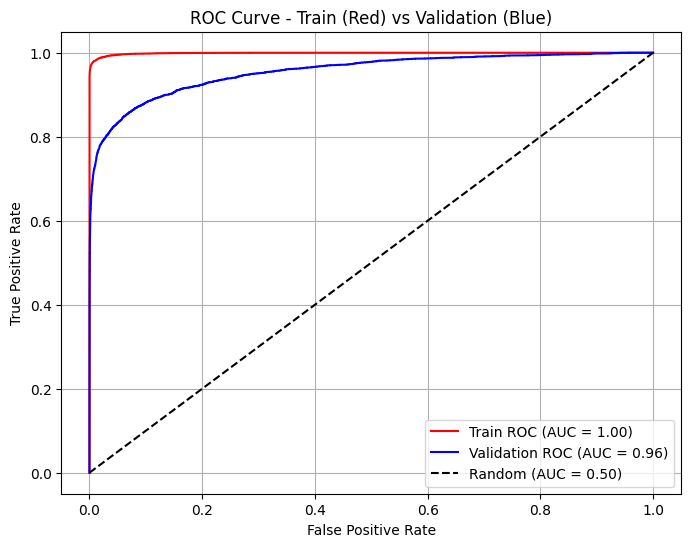

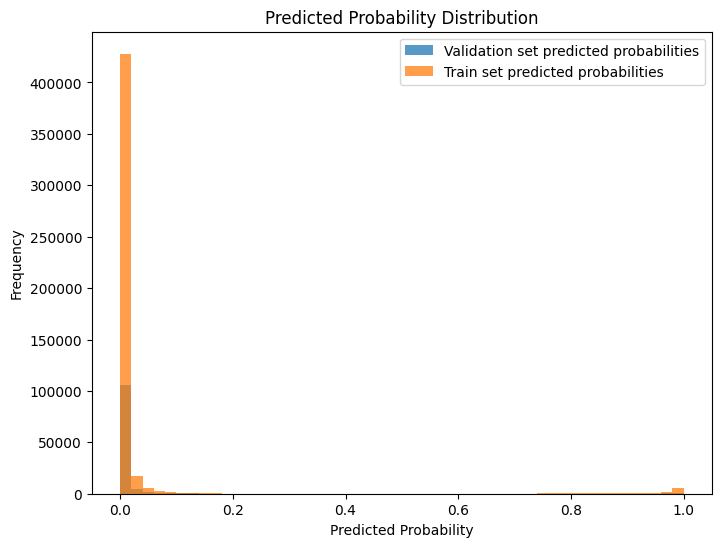

🏃 View run XGboost_Model_Lambda at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/182cf0b9580b433aa9faed44aedcc997
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

pipeline = Pipeline([
        ('preprocess', preprocess),
        ('model', XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=25, min_child_weight=1, reg_alpha=0, reg_lambda=10)),
    ])
pipeline.fit(X_train, y_train)

with mlflow.start_run(run_name='XGboost_Model_Lambda'):

    mlflow.sklearn.log_model(pipeline, "xgboost_model")

    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
    y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
    auc_train = auc(fpr_train, tpr_train)
    auc_valid = auc(fpr_valid, tpr_valid)

    mlflow.log_metric("train_auc", auc_train)
    mlflow.log_metric("valid_auc", auc_valid)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='red', label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_valid, tpr_valid, color='blue', label=f'Validation ROC (AUC = {auc_valid:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train (Red) vs Validation (Blue)')
    plt.legend(loc='lower right')
    plt.grid(True)
    roc_image_path = "roc_curve.png"
    plt.savefig(roc_image_path)
    mlflow.log_artifact(roc_image_path)
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.hist(y_valid_proba, bins=50, alpha=0.75, label="Validation set predicted probabilities")
    plt.hist(y_train_proba, bins=50, alpha=0.75, label="Train set predicted probabilities")
    plt.title("Predicted Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    prob_dist_image_path = "probability_distribution.png"
    plt.savefig(prob_dist_image_path)
    mlflow.log_artifact(prob_dist_image_path)
    plt.show()
    plt.close()

    mlflow.log_param("preprocess_steps", [name for name, _ in preprocess.steps])
    mlflow.log_param("drop_high_nan", "enabled")
    mlflow.log_param("drop_high_nan_threashold", "0.8")
    num_imputer = imputer.named_transformers_['num']
    mlflow.log_param("num_imputer_strategy", num_imputer.strategy)
    cat_imputer = imputer.named_transformers_['cat']
    mlflow.log_param("cat_imputer_strategy", cat_imputer.strategy)
    mlflow.log_param("cat_imputer_fill_value", cat_imputer.fill_value)
    mlflow.log_param("categorical_encoder", "CategoricalEncoder()")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("rfe_steps", "0.1")
    mlflow.log_param("rfe_features_left", "100")
    mlflow.log_param("xgboost_max_depth", 25)
    mlflow.log_param("xgboost_min_child_weight", 1)
    mlflow.log_param("xgboost_reg_alpha", 0)
    mlflow.log_param("xgboost_reg_lambda", 10)


It is also interesting how this will work without removing costum columns. Hence, we will built pipeline using only cleaner and log the experiment on mlflow.

2025/04/26 10:17:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


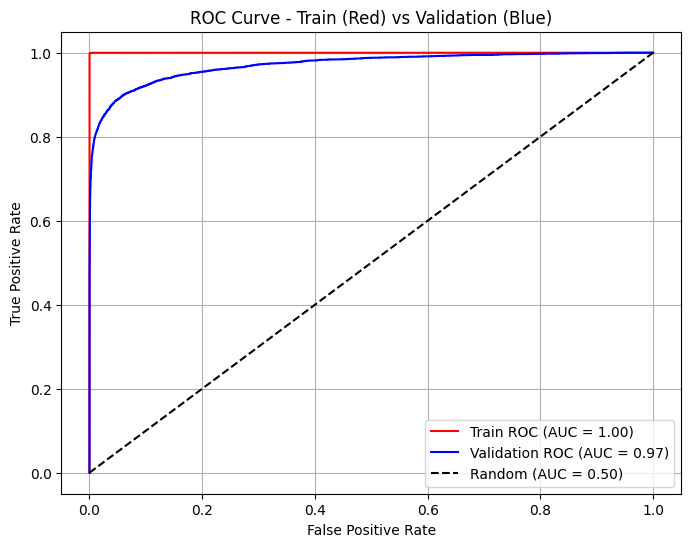

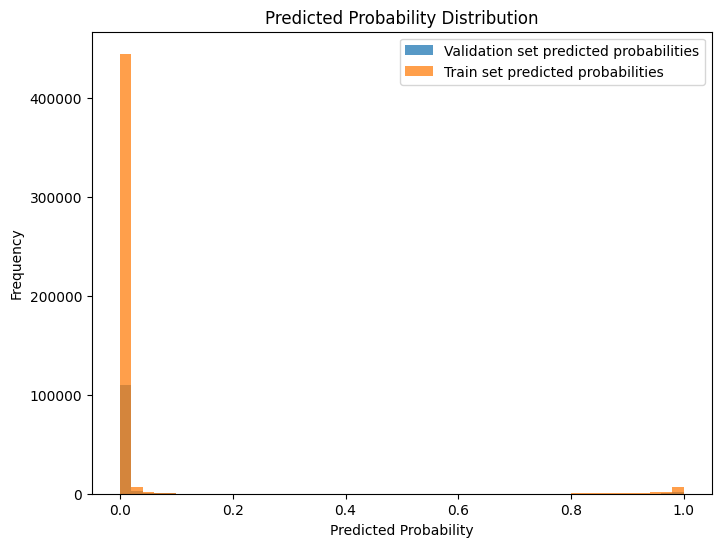

🏃 View run XGboost_Model_Dirty_lambda at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/81bff65412514e87a7b5dbba2ebe1f90
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

preprocess = cleaner

pipeline = Pipeline([
        ('preprocess', preprocess),
        ('model', XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=25, min_child_weight=1, reg_alpha=0, reg_lambda=10)),
    ])
pipeline.fit(X_train, y_train)

with mlflow.start_run(run_name='XGboost_Model_Dirty_lambda'):

    mlflow.sklearn.log_model(pipeline, "xgboost_model")

    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
    y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
    auc_train = auc(fpr_train, tpr_train)
    auc_valid = auc(fpr_valid, tpr_valid)

    mlflow.log_metric("train_auc", auc_train)
    mlflow.log_metric("valid_auc", auc_valid)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='red', label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_valid, tpr_valid, color='blue', label=f'Validation ROC (AUC = {auc_valid:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train (Red) vs Validation (Blue)')
    plt.legend(loc='lower right')
    plt.grid(True)
    roc_image_path = "roc_curve.png"
    plt.savefig(roc_image_path)
    mlflow.log_artifact(roc_image_path)
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.hist(y_valid_proba, bins=50, alpha=0.75, label="Validation set predicted probabilities")
    plt.hist(y_train_proba, bins=50, alpha=0.75, label="Train set predicted probabilities")
    plt.title("Predicted Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    prob_dist_image_path = "probability_distribution.png"
    plt.savefig(prob_dist_image_path)
    mlflow.log_artifact(prob_dist_image_path)
    plt.show()
    plt.close()

    mlflow.log_param("preprocess_steps", [name for name, _ in preprocess.steps])
    mlflow.log_param("drop_high_nan", "enabled")
    mlflow.log_param("drop_high_nan_threashold", "0.8")
    num_imputer = imputer.named_transformers_['num']
    mlflow.log_param("num_imputer_strategy", num_imputer.strategy)
    cat_imputer = imputer.named_transformers_['cat']
    mlflow.log_param("cat_imputer_strategy", cat_imputer.strategy)
    mlflow.log_param("cat_imputer_fill_value", cat_imputer.fill_value)
    mlflow.log_param("categorical_encoder", "CategoricalEncoder()")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("rfe_steps", "0.1")
    mlflow.log_param("rfe_features_left", "100")
    mlflow.log_param("xgboost_max_depth", 25)
    mlflow.log_param("xgboost_min_child_weight", 1)
    mlflow.log_param("xgboost_reg_alpha", 0)
    mlflow.log_param("xgboost_reg_lambda", 10)


It appears that the model performs better without feature engineering. However, we risk overfitting, as a training ROC of 1 is quite high. Therefore, it seems logical to explore different types of feature engineering from this point onward. Additionally, we can consider using undersampling or oversampling techniques. In later chapters, we will try both approaches.

## 5. Different Feature Engineering

In [31]:
class CustomCorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.9):
        self.threshold = threshold
        self.features_to_remove = []

    def fit(self, X, y):
        X_corr = X.copy()
        target_col = 'isFraud'
        X_corr[target_col] = y
        corr_matrix = X_corr.corr().abs()
        threshold = self.threshold
        high_corr_pairs = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > threshold:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

        for feat1, feat2, _ in high_corr_pairs:
            if feat1 == target_col or feat2 == target_col:
                continue
            if abs(X[feat1].corr(y)) < abs(X[feat2].corr(y)):
                self.features_to_remove.append(feat1)
            else:
                self.features_to_remove.append(feat2)

        self.features_to_remove = list(set(self.features_to_remove))
        
        return self
        
    def transform(self, X):
        X_transformed = X.drop(columns=self.features_to_remove)    
        return X_transformed

In [32]:
preprocess = Pipeline([
        ('cleaner', cleaner),
        ('corelation_filter', CustomCorrelationFilter(0.8)),
    ])

X_train_filtered = preprocess.fit_transform(X_train, y_train)
X_valid_filtered = preprocess.transform(X_valid)
X_train_filtered

,num__TransactionID,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__addr2,num__dist1,num__C2,...,cat__id_29_nan,cat__id_35_T,cat__id_35_nan,cat__id_36_T,cat__id_36_nan,cat__id_37_nan,cat__id_38_T,cat__id_38_nan,cat__DeviceType_mobile,cat__DeviceType_nan
5307,-1.700744,-0.322223,-1.003053,-0.181902,-0.281587,0.644600,0.241728,0.069510,-0.044443,-0.091973,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
191582,-0.608256,-0.473144,-1.231887,-0.424641,2.808078,0.644600,0.075003,0.069510,-0.184160,-0.091973,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
260168,-0.206005,-0.419880,0.546113,-0.603501,-0.281587,-0.814173,1.919395,0.069510,-0.184160,-0.066138,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
18516,-1.623274,-0.148516,-0.792592,1.408679,-0.281587,0.644600,-1.727707,0.069510,-0.184160,-0.091973,...,0.0,2.570359,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
47538,-1.453063,-0.254435,1.260171,0.967916,-0.281587,-2.370198,0.345931,0.069510,-0.184160,-0.091973,...,0.0,2.570359,0.0,-0.108591,0.0,0.0,2.798215,0.0,3.097621,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,-1.085156,-0.466272,1.407351,1.229819,5.014982,-1.519247,0.043743,5.946749,-0.184160,-0.091973,...,0.0,2.570359,0.0,-0.108591,0.0,0.0,2.798215,0.0,-0.322828,0.0
259178,-0.211811,0.944352,1.393266,-1.606398,-0.281587,0.644600,0.345931,0.069510,-0.184160,-0.091973,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
365838,0.413741,0.088741,-1.351100,1.229819,-0.281587,0.644600,-1.050388,0.069510,-0.212925,-0.072597,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
131932,-0.958099,-0.322223,-0.082005,-0.264944,-0.281587,0.644600,-0.914924,0.069510,-0.184160,-0.091973,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0


In [33]:
X_valid_filtered

,num__TransactionID,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__addr2,num__dist1,num__C2,...,cat__id_29_nan,cat__id_35_T,cat__id_35_nan,cat__id_36_T,cat__id_36_nan,cat__id_37_nan,cat__id_38_T,cat__id_38_nan,cat__DeviceType_mobile,cat__DeviceType_nan
470624,1.028302,2.495212,-0.423723,0.757116,-0.281587,0.595974,0.991989,0.06951,-0.184160,-0.091973,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
565820,1.586619,-0.112504,0.539377,-0.264944,-0.281587,0.644600,1.919395,0.06951,-0.217035,-0.091973,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
284083,-0.065745,-0.369039,-0.102418,-1.606398,-0.281587,0.595974,0.241728,0.06951,-0.192379,-0.091973,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
239689,-0.326113,-0.145979,1.221386,1.165940,2.808078,-1.494934,0.075003,0.06951,-0.184160,-0.079055,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
281855,-0.078813,-0.114834,1.142182,0.814607,-0.281587,0.644600,0.075003,0.06951,-0.184160,-0.008010,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373780,0.460320,-0.093439,-1.563603,1.229819,-0.281587,0.644600,-0.914924,0.06951,-0.184160,-0.091973,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
245203,-0.293773,-0.076492,-0.232451,1.229819,-0.281587,0.644600,-0.633577,0.06951,-0.003349,-0.091973,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,-0.322828,0.0
450760,0.911802,-0.320049,1.272623,-1.012325,2.808078,-1.494934,0.075003,0.06951,-0.184160,-0.072597,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,3.097621,0.0
529422,1.373148,-0.480762,1.221386,1.165940,2.808078,-1.494934,0.075003,0.06951,-0.184160,-0.085514,...,0.0,-0.389051,0.0,-0.108591,0.0,0.0,-0.357371,0.0,3.097621,0.0


Now we cann use RFE to search for the best sets of columns.

In [34]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

best_auc = 0
best_k = 0
best_features = None

for k in [50, 100, 130, 150, 165]: 
    model = XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=25, min_child_weight=1, reg_alpha=0, reg_lambda=10)
    rfe = RFE(estimator=model, n_features_to_select=k, step=0.1)
    rfe.fit(X_train_filtered, y_train)
    X_train_k = rfe.transform(X_train_filtered)
    X_valid_k = rfe.transform(X_valid_filtered)
    model.fit(X_train_k, y_train)
    y_pred = model.predict_proba(X_valid_k)[:, 1]
    auc = roc_auc_score(y_valid, y_pred)
    print(f'k={k}, ROC AUC={auc}')
    if auc > best_auc:
        best_auc = auc
        best_k = k
        best_features = X_train_filtered.columns[rfe.support_]

print(f"\nBest k = {best_k} with ROC AUC = {best_auc}")
print(f"Selected features:\n{best_features.tolist()}")

k=50, ROC AUC=0.9335868071201057
k=100, ROC AUC=0.9652223316118544
k=130, ROC AUC=0.9683377012308726
k=150, ROC AUC=0.9678994819282395
k=165, ROC AUC=0.9678994819282395

Best k = 130 with ROC AUC = 0.9683377012308726
Selected features:
['num__TransactionID', 'num__TransactionAmt', 'num__card1', 'num__card2', 'num__card3', 'num__card5', 'num__addr1', 'num__addr2', 'num__dist1', 'num__C2', 'num__C3', 'num__C9', 'num__D1', 'num__D3', 'num__D4', 'num__D5', 'num__D10', 'num__D11', 'num__D15', 'num__V2', 'num__V3', 'num__V5', 'num__V6', 'num__V9', 'num__V10', 'num__V12', 'num__V18', 'num__V20', 'num__V23', 'num__V26', 'num__V29', 'num__V35', 'num__V38', 'num__V40', 'num__V45', 'num__V46', 'num__V47', 'num__V52', 'num__V53', 'num__V55', 'num__V56', 'num__V62', 'num__V67', 'num__V75', 'num__V77', 'num__V78', 'num__V83', 'num__V86', 'num__V98', 'num__V108', 'num__V109', 'num__V111', 'num__V114', 'num__V115', 'num__V120', 'num__V121', 'num__V122', 'num__V123', 'num__V124', 'num__V169', 'num__V17

In [35]:
new_columns_8 = ['num__TransactionID', 'num__TransactionAmt', 'num__card1', 'num__card2', 'num__card3', 'num__card5', 'num__addr1', 'num__addr2', 'num__dist1', 'num__C2', 'num__C3', 
                 'num__C9', 'num__D1', 'num__D3', 'num__D4', 'num__D5', 'num__D10', 'num__D11', 'num__D15', 'num__V2', 'num__V3', 'num__V5', 'num__V6', 'num__V9', 'num__V10', 
                 'num__V12', 'num__V18', 'num__V20', 'num__V23', 'num__V26', 'num__V29', 'num__V35', 'num__V38', 'num__V40', 'num__V45', 'num__V46', 'num__V47', 'num__V52',
                 'num__V53', 'num__V55', 'num__V56', 'num__V62', 'num__V67', 'num__V75', 'num__V77', 'num__V78', 'num__V83', 'num__V86', 'num__V98', 'num__V108', 'num__V109', 
                 'num__V111', 'num__V114', 'num__V115', 'num__V120', 'num__V121', 'num__V122', 'num__V123', 'num__V124', 'num__V169', 'num__V171', 'num__V173', 'num__V174', 
                 'num__V175', 'num__V181', 'num__V184', 'num__V195', 'num__V197', 'num__V199', 'num__V201', 'num__V205', 'num__V208', 'num__V209', 'num__V220', 'num__V222',
                 'num__V223', 'num__V226', 'num__V232', 'num__V234', 'num__V235', 'num__V239', 'num__V240', 'num__V247', 'num__V250', 'num__V257', 'num__V258', 'num__V260', 
                 'num__V262', 'num__V268', 'num__V271', 'num__V277', 'num__V281', 'num__V282', 'num__V283', 'num__V284', 'num__V286', 'num__V287', 'num__V289', 'num__V290',
                 'num__V301', 'num__V309', 'num__V310', 'num__V312', 'num__V315', 'num__V320', 'num__id_01', 'num__id_02', 'num__id_05', 'num__id_06', 'num__id_11', 'num__id_13',
                 'num__id_17', 'num__id_19', 'num__id_20', 'woe_cat__card4', 'woe_cat__card6', 'woe_cat__P_emaildomain', 'woe_cat__R_emaildomain', 'woe_cat__M4', 'woe_cat__id_31',
                 'woe_cat__DeviceInfo', 'cat__M5_T', 'cat__M5_unknown', 'cat__M6_T', 'cat__M7_T', 'cat__M8_T', 'cat__id_35_T', 'cat__id_36_T', 'cat__id_38_T', 
                 'cat__DeviceType_mobile']

In [36]:
preprocess = Pipeline([
    ('cleaner', cleaner),
    ('selector', ColumnSelector(columns=new_columns_8)),
    ])

2025/04/26 10:42:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


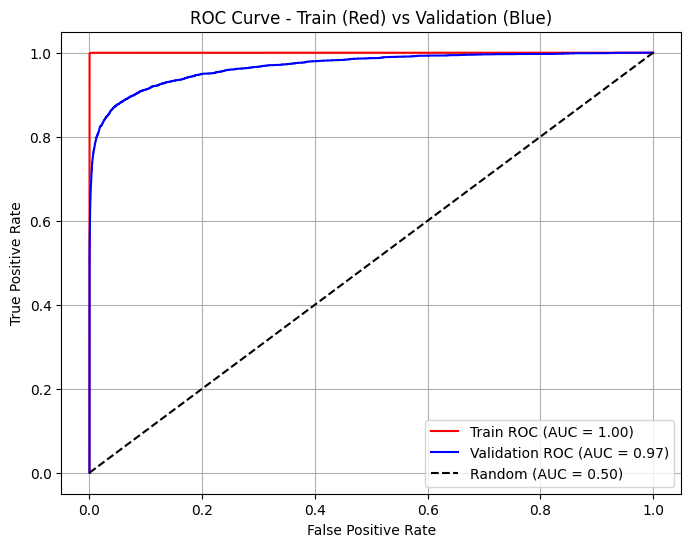

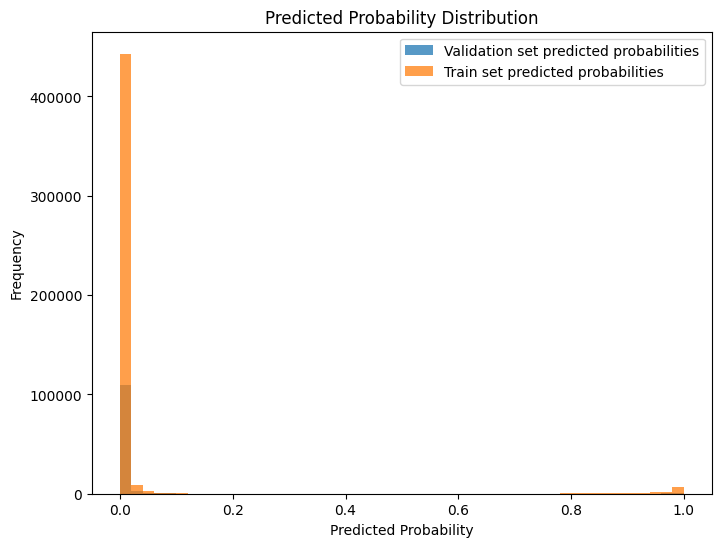

🏃 View run XGboost_Model_drfe_8 at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/ba06a6505421429ca7126b6e2cde9537
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

pipeline = Pipeline([
        ('preprocess', preprocess),
        ('model', XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=25, min_child_weight=1, reg_alpha=0, reg_lambda=10)),
    ])
pipeline.fit(X_train, y_train)

with mlflow.start_run(run_name='XGboost_Model_drfe_8'):

    mlflow.sklearn.log_model(pipeline, "xgboost_model")

    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
    y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
    auc_train = auc(fpr_train, tpr_train)
    auc_valid = auc(fpr_valid, tpr_valid)

    mlflow.log_metric("train_auc", auc_train)
    mlflow.log_metric("valid_auc", auc_valid)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='red', label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_valid, tpr_valid, color='blue', label=f'Validation ROC (AUC = {auc_valid:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train (Red) vs Validation (Blue)')
    plt.legend(loc='lower right')
    plt.grid(True)
    roc_image_path = "roc_curve.png"
    plt.savefig(roc_image_path)
    mlflow.log_artifact(roc_image_path)
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.hist(y_valid_proba, bins=50, alpha=0.75, label="Validation set predicted probabilities")
    plt.hist(y_train_proba, bins=50, alpha=0.75, label="Train set predicted probabilities")
    plt.title("Predicted Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    prob_dist_image_path = "probability_distribution.png"
    plt.savefig(prob_dist_image_path)
    mlflow.log_artifact(prob_dist_image_path)
    plt.show()
    plt.close()

    columns_df = pd.DataFrame(new_columns_8, columns=["selected_column"]) 
    columns_df.to_csv("selected_columns.csv", index=False)
    mlflow.log_artifact("selected_columns.csv")
    del columns_df

    mlflow.log_param("corelation_filter_threshold", 0.8)
    mlflow.log_param("preprocess_steps", [name for name, _ in preprocess.steps])
    mlflow.log_param("drop_high_nan", "enabled")
    mlflow.log_param("drop_high_nan_threashold", "0.8")
    num_imputer = imputer.named_transformers_['num']
    mlflow.log_param("num_imputer_strategy", num_imputer.strategy)
    cat_imputer = imputer.named_transformers_['cat']
    mlflow.log_param("cat_imputer_strategy", cat_imputer.strategy)
    mlflow.log_param("cat_imputer_fill_value", cat_imputer.fill_value)
    mlflow.log_param("categorical_encoder", "CategoricalEncoder()")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("rfe_steps", "0.1")
    mlflow.log_param("rfe_features_left", "130")
    mlflow.log_param("xgboost_max_depth", 25)
    mlflow.log_param("xgboost_min_child_weight", 1)
    mlflow.log_param("xgboost_reg_alpha", 0)
    mlflow.log_param("xgboost_reg_lambda", 10)

Now, I think it’s worth repeating this process with a higher correlation filter threshold, as we see that 0.8 filtered out too many features.

In [38]:
from sklearn.pipeline import Pipeline

preprocess = Pipeline([
        ('cleaner', cleaner),
        ('corelation_filter', CustomCorrelationFilter(0.9)),
    ])

X_train_filtered = preprocess.fit_transform(X_train, y_train)
X_valid_filtered = preprocess.transform(X_valid)
X_train_filtered

,num__TransactionID,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__addr2,num__dist1,num__C2,...,cat__id_35_T,cat__id_35_nan,cat__id_36_T,cat__id_36_nan,cat__id_37_T,cat__id_37_nan,cat__id_38_T,cat__id_38_nan,cat__DeviceType_mobile,cat__DeviceType_nan
5307,-1.700744,-0.322223,-1.003053,-0.181902,-0.281587,0.644600,0.241728,0.069510,-0.044443,-0.091973,...,-0.389051,0.0,-0.108591,0.0,-0.479517,0.0,-0.357371,0.0,-0.322828,0.0
191582,-0.608256,-0.473144,-1.231887,-0.424641,2.808078,0.644600,0.075003,0.069510,-0.184160,-0.091973,...,-0.389051,0.0,-0.108591,0.0,2.085434,0.0,-0.357371,0.0,-0.322828,0.0
260168,-0.206005,-0.419880,0.546113,-0.603501,-0.281587,-0.814173,1.919395,0.069510,-0.184160,-0.066138,...,-0.389051,0.0,-0.108591,0.0,-0.479517,0.0,-0.357371,0.0,-0.322828,0.0
18516,-1.623274,-0.148516,-0.792592,1.408679,-0.281587,0.644600,-1.727707,0.069510,-0.184160,-0.091973,...,2.570359,0.0,-0.108591,0.0,2.085434,0.0,-0.357371,0.0,-0.322828,0.0
47538,-1.453063,-0.254435,1.260171,0.967916,-0.281587,-2.370198,0.345931,0.069510,-0.184160,-0.091973,...,2.570359,0.0,-0.108591,0.0,2.085434,0.0,2.798215,0.0,3.097621,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110268,-1.085156,-0.466272,1.407351,1.229819,5.014982,-1.519247,0.043743,5.946749,-0.184160,-0.091973,...,2.570359,0.0,-0.108591,0.0,2.085434,0.0,2.798215,0.0,-0.322828,0.0
259178,-0.211811,0.944352,1.393266,-1.606398,-0.281587,0.644600,0.345931,0.069510,-0.184160,-0.091973,...,-0.389051,0.0,-0.108591,0.0,-0.479517,0.0,-0.357371,0.0,-0.322828,0.0
365838,0.413741,0.088741,-1.351100,1.229819,-0.281587,0.644600,-1.050388,0.069510,-0.212925,-0.072597,...,-0.389051,0.0,-0.108591,0.0,-0.479517,0.0,-0.357371,0.0,-0.322828,0.0
131932,-0.958099,-0.322223,-0.082005,-0.264944,-0.281587,0.644600,-0.914924,0.069510,-0.184160,-0.091973,...,-0.389051,0.0,-0.108591,0.0,-0.479517,0.0,-0.357371,0.0,-0.322828,0.0


In [39]:
X_valid_filtered

,num__TransactionID,num__TransactionAmt,num__card1,num__card2,num__card3,num__card5,num__addr1,num__addr2,num__dist1,num__C2,...,cat__id_35_T,cat__id_35_nan,cat__id_36_T,cat__id_36_nan,cat__id_37_T,cat__id_37_nan,cat__id_38_T,cat__id_38_nan,cat__DeviceType_mobile,cat__DeviceType_nan
470624,1.028302,2.495212,-0.423723,0.757116,-0.281587,0.595974,0.991989,0.06951,-0.184160,-0.091973,...,-0.389051,0.0,-0.108591,0.0,-0.479517,0.0,-0.357371,0.0,-0.322828,0.0
565820,1.586619,-0.112504,0.539377,-0.264944,-0.281587,0.644600,1.919395,0.06951,-0.217035,-0.091973,...,-0.389051,0.0,-0.108591,0.0,-0.479517,0.0,-0.357371,0.0,-0.322828,0.0
284083,-0.065745,-0.369039,-0.102418,-1.606398,-0.281587,0.595974,0.241728,0.06951,-0.192379,-0.091973,...,-0.389051,0.0,-0.108591,0.0,-0.479517,0.0,-0.357371,0.0,-0.322828,0.0
239689,-0.326113,-0.145979,1.221386,1.165940,2.808078,-1.494934,0.075003,0.06951,-0.184160,-0.079055,...,-0.389051,0.0,-0.108591,0.0,-0.479517,0.0,-0.357371,0.0,-0.322828,0.0
281855,-0.078813,-0.114834,1.142182,0.814607,-0.281587,0.644600,0.075003,0.06951,-0.184160,-0.008010,...,-0.389051,0.0,-0.108591,0.0,-0.479517,0.0,-0.357371,0.0,-0.322828,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373780,0.460320,-0.093439,-1.563603,1.229819,-0.281587,0.644600,-0.914924,0.06951,-0.184160,-0.091973,...,-0.389051,0.0,-0.108591,0.0,-0.479517,0.0,-0.357371,0.0,-0.322828,0.0
245203,-0.293773,-0.076492,-0.232451,1.229819,-0.281587,0.644600,-0.633577,0.06951,-0.003349,-0.091973,...,-0.389051,0.0,-0.108591,0.0,-0.479517,0.0,-0.357371,0.0,-0.322828,0.0
450760,0.911802,-0.320049,1.272623,-1.012325,2.808078,-1.494934,0.075003,0.06951,-0.184160,-0.072597,...,-0.389051,0.0,-0.108591,0.0,2.085434,0.0,-0.357371,0.0,3.097621,0.0
529422,1.373148,-0.480762,1.221386,1.165940,2.808078,-1.494934,0.075003,0.06951,-0.184160,-0.085514,...,-0.389051,0.0,-0.108591,0.0,2.085434,0.0,-0.357371,0.0,3.097621,0.0


In [41]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

best_auc = 0
best_k = 0
best_features = None

for k in [100, 130, 150, 170, 200, 231]: 
    model = XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=25, min_child_weight=1, reg_alpha=0, reg_lambda=10)
    rfe = RFE(estimator=model, n_features_to_select=k, step=0.1)
    rfe.fit(X_train_filtered, y_train)
    X_train_k = rfe.transform(X_train_filtered)
    X_valid_k = rfe.transform(X_valid_filtered)
    model.fit(X_train_k, y_train)
    y_pred = model.predict_proba(X_valid_k)[:, 1]
    auc = roc_auc_score(y_valid, y_pred)
    print(f'k={k}, ROC AUC={auc}')
    if auc > best_auc:
        best_auc = auc
        best_k = k
        best_features = X_train_filtered.columns[rfe.support_]

print(f"\nBest k = {best_k} with ROC AUC = {best_auc}")
print(f"Selected features:\n{best_features.tolist()}")

k=100, ROC AUC=0.9526366387074683
k=130, ROC AUC=0.9643010490680489
k=150, ROC AUC=0.9697389550086388
k=170, ROC AUC=0.9698757786568533
k=200, ROC AUC=0.9697642376280354
k=231, ROC AUC=0.9699247694252854

Best k = 231 with ROC AUC = 0.9699247694252854
Selected features:
['num__TransactionID', 'num__TransactionAmt', 'num__card1', 'num__card2', 'num__card3', 'num__card5', 'num__addr1', 'num__addr2', 'num__dist1', 'num__C2', 'num__C3', 'num__C9', 'num__C13', 'num__D1', 'num__D3', 'num__D4', 'num__D5', 'num__D10', 'num__D11', 'num__D15', 'num__V1', 'num__V2', 'num__V3', 'num__V5', 'num__V6', 'num__V7', 'num__V8', 'num__V9', 'num__V10', 'num__V12', 'num__V14', 'num__V18', 'num__V20', 'num__V23', 'num__V24', 'num__V25', 'num__V26', 'num__V27', 'num__V29', 'num__V35', 'num__V37', 'num__V38', 'num__V40', 'num__V41', 'num__V43', 'num__V45', 'num__V46', 'num__V47', 'num__V48', 'num__V52', 'num__V53', 'num__V55', 'num__V56', 'num__V61', 'num__V62', 'num__V63', 'num__V65', 'num__V66', 'num__V67', 

In [43]:
new_columns_9 = ['num__TransactionID', 'num__TransactionAmt', 'num__card1', 'num__card2', 'num__card3', 'num__card5', 'num__addr1', 'num__addr2', 'num__dist1', 'num__C2', 
                 'num__C3', 'num__C9', 'num__C13', 'num__D1', 'num__D3', 'num__D4', 'num__D5', 'num__D10', 'num__D11', 'num__D15', 'num__V1', 'num__V2', 'num__V3', 'num__V5', 
                 'num__V6', 'num__V7', 'num__V8', 'num__V9', 'num__V10', 'num__V12', 'num__V14', 'num__V18', 'num__V20', 'num__V23', 'num__V24', 'num__V25', 'num__V26', 'num__V27',
                 'num__V29', 'num__V35', 'num__V37', 'num__V38', 'num__V40', 'num__V41', 'num__V43', 'num__V45', 'num__V46', 'num__V47', 'num__V48', 'num__V52', 'num__V53', 
                 'num__V55', 'num__V56', 'num__V61', 'num__V62', 'num__V63', 'num__V65', 'num__V66', 'num__V67', 'num__V68', 'num__V74', 'num__V75', 'num__V77', 'num__V78',
                 'num__V79', 'num__V81', 'num__V82', 'num__V83', 'num__V85', 'num__V86', 'num__V87', 'num__V88', 'num__V89', 'num__V98', 'num__V99', 'num__V100', 'num__V107',
                 'num__V108', 'num__V109', 'num__V110', 'num__V111', 'num__V112', 'num__V114', 'num__V115', 'num__V116', 'num__V117', 'num__V118', 'num__V119', 'num__V120',
                 'num__V121', 'num__V122', 'num__V123', 'num__V124', 'num__V125', 'num__V130', 'num__V131', 'num__V137', 'num__V169', 'num__V170', 'num__V171', 'num__V172', 
                 'num__V173', 'num__V174', 'num__V175', 'num__V181', 'num__V184', 'num__V185', 'num__V187', 'num__V188', 'num__V189', 'num__V191', 'num__V195', 'num__V197', 
                 'num__V199', 'num__V201', 'num__V205', 'num__V208', 'num__V209', 'num__V210', 'num__V214', 'num__V215', 'num__V216', 'num__V220', 'num__V222', 'num__V223', 
                 'num__V225', 'num__V226', 'num__V227', 'num__V228', 'num__V230', 'num__V232', 'num__V234', 'num__V235', 'num__V239', 'num__V240', 'num__V241', 'num__V243',
                 'num__V244', 'num__V247', 'num__V249', 'num__V250', 'num__V252', 'num__V256', 'num__V257', 'num__V258', 'num__V259', 'num__V260', 'num__V261', 'num__V262',
                 'num__V263', 'num__V264', 'num__V265', 'num__V266', 'num__V267', 'num__V268', 'num__V271', 'num__V277', 'num__V281', 'num__V282', 'num__V283', 'num__V284',
                 'num__V285', 'num__V286', 'num__V287', 'num__V288', 'num__V289', 'num__V290', 'num__V292', 'num__V296', 'num__V301', 'num__V305', 'num__V307', 'num__V309', 
                 'num__V310', 'num__V312', 'num__V314', 'num__V315', 'num__V320', 'num__id_01', 'num__id_02', 'num__id_05', 'num__id_06', 'num__id_11', 'num__id_13', 'num__id_17',
                 'num__id_19', 'num__id_20', 'woe_cat__ProductCD', 'woe_cat__card4', 'woe_cat__card6', 'woe_cat__P_emaildomain', 'woe_cat__R_emaildomain', 'woe_cat__M4', 
                 'woe_cat__id_15', 'woe_cat__id_31', 'woe_cat__DeviceInfo', 'cat__M1_unknown', 'cat__M1_nan', 'cat__M2_T', 'cat__M2_nan', 'cat__M3_T', 'cat__M3_nan', 
                 'cat__M5_T', 'cat__M5_unknown', 'cat__M5_nan', 'cat__M6_T', 'cat__M6_unknown', 'cat__M6_nan', 'cat__M7_T', 'cat__M7_nan', 'cat__M8_T', 'cat__M8_unknown', 
                 'cat__M8_nan', 'cat__M9_T', 'cat__M9_nan', 'cat__id_12_nan', 'cat__id_16_NotFound', 'cat__id_16_nan', 'cat__id_28_New', 'cat__id_28_nan', 'cat__id_29_nan', 
                 'cat__id_35_T', 'cat__id_35_nan', 'cat__id_36_T', 'cat__id_36_nan', 'cat__id_37_T', 'cat__id_37_nan', 'cat__id_38_T', 'cat__id_38_nan', 'cat__DeviceType_mobile', 
                 'cat__DeviceType_nan']

In [44]:
preprocess = Pipeline([
    ('cleaner', cleaner),
    ('selector', ColumnSelector(columns=new_columns_9)),
    ])
X_train_processed = preprocess.fit_transform(X_train, y_train)
X_valid_processed = preprocess.transform(X_valid)

In [45]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

max_depths = [10, 25, 40]
min_child_weights = [1, 3, 10]
reg_lambdas = [0, 10, 50]
best_reg_lambda = 0
reg_alphas = [0, 10, 50]
best_roc_auc = 0
best_max_depth = 0
best_min_child_weight = 0

for max_depth in max_depths:
    for min_child_weight in min_child_weights:
        for reg_lambda in reg_lambdas:
            for reg_alpha in reg_alphas:
                print(f'processing: max_depth:{max_depth}, min_child_weight:{min_child_weight}, reg_lambda={reg_lambda}, reg_alpha={reg_alpha}', end=' ')
                xgb = XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=max_depth, min_child_weight=min_child_weight, reg_alpha=reg_alpha, reg_lambda=reg_lambda)
                xgb.fit(X_train_processed, y_train)
                y_predict = xgb.predict_proba(X_valid_processed)[:, 1]
                roc_auc = roc_auc_score(y_valid, y_predict)
                print(f'and roc_auc={roc_auc}')
                if roc_auc > best_roc_auc:
                    best_roc_auc = roc_auc
                    best_max_depth = max_depth
                    best_min_child_weight = min_child_weight
                    best_reg_lambda = reg_lambda
                    best_reg_alpha = reg_alpha
print(f"auc:{best_roc_auc}, max_depth:{best_max_depth}, min_child_weight:{best_min_child_weight}, reg_alpha:{best_reg_alpha}, reg_lambda={best_reg_lambda}")

processing: max_depth:10, min_child_weight:1, reg_lambda=0, reg_alpha=0 and roc_auc=0.9639250404950465
processing: max_depth:10, min_child_weight:1, reg_lambda=0, reg_alpha=10 and roc_auc=0.9620641562739822
processing: max_depth:10, min_child_weight:1, reg_lambda=0, reg_alpha=50 and roc_auc=0.942638756054382
processing: max_depth:10, min_child_weight:1, reg_lambda=10, reg_alpha=0 and roc_auc=0.9610633075961568
processing: max_depth:10, min_child_weight:1, reg_lambda=10, reg_alpha=10 and roc_auc=0.9606812775280253
processing: max_depth:10, min_child_weight:1, reg_lambda=10, reg_alpha=50 and roc_auc=0.9423803721146107
processing: max_depth:10, min_child_weight:1, reg_lambda=50, reg_alpha=0 and roc_auc=0.9530339424838048
processing: max_depth:10, min_child_weight:1, reg_lambda=50, reg_alpha=10 and roc_auc=0.953874452938317
processing: max_depth:10, min_child_weight:1, reg_lambda=50, reg_alpha=50 and roc_auc=0.9406460314200271
processing: max_depth:10, min_child_weight:3, reg_lambda=0, reg

2025/04/26 12:18:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


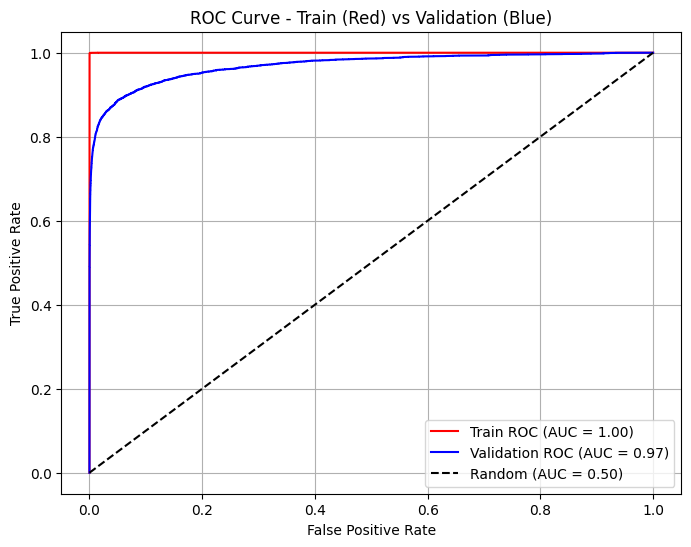

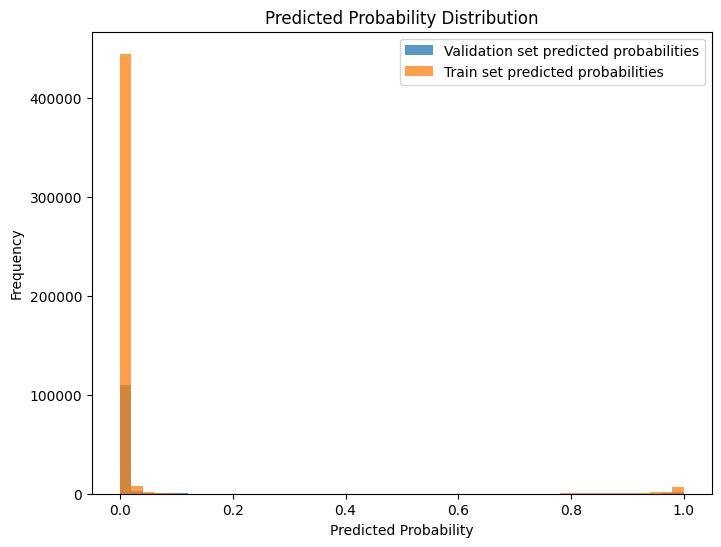

🏃 View run XGboost_Model_drfe_9 at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1/runs/5501f19d1435439da8b8d4bd5de47568
🧪 View experiment at: https://dagshub.com/zhorzholianimate/IEEE-CIS-Fraud-Detection.mlflow/#/experiments/1


In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

preprocess = Pipeline([
    ('cleaner', cleaner),
    ('selector', ColumnSelector(columns=new_columns_9)),
    ])
pipeline = Pipeline([
        ('preprocess', preprocess),
        ('model', XGBClassifier(n_jobs = -1, eval_metric="auc", max_depth=25, min_child_weight=1, reg_alpha=0, reg_lambda=10)),
    ])
pipeline.fit(X_train, y_train)

with mlflow.start_run(run_name='XGboost_Model_drfe_9'):

    mlflow.sklearn.log_model(pipeline, "xgboost_model")

    y_train_proba = pipeline.predict_proba(X_train)[:, 1]
    y_valid_proba = pipeline.predict_proba(X_valid)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
    fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_proba)
    auc_train = auc(fpr_train, tpr_train)
    auc_valid = auc(fpr_valid, tpr_valid)

    mlflow.log_metric("train_auc", auc_train)
    mlflow.log_metric("valid_auc", auc_valid)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, color='red', label=f'Train ROC (AUC = {auc_train:.2f})')
    plt.plot(fpr_valid, tpr_valid, color='blue', label=f'Validation ROC (AUC = {auc_valid:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Train (Red) vs Validation (Blue)')
    plt.legend(loc='lower right')
    plt.grid(True)
    roc_image_path = "roc_curve.png"
    plt.savefig(roc_image_path)
    mlflow.log_artifact(roc_image_path)
    plt.show()
    plt.close()

    plt.figure(figsize=(8, 6))
    plt.hist(y_valid_proba, bins=50, alpha=0.75, label="Validation set predicted probabilities")
    plt.hist(y_train_proba, bins=50, alpha=0.75, label="Train set predicted probabilities")
    plt.title("Predicted Probability Distribution")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.legend(loc="upper right")
    prob_dist_image_path = "probability_distribution.png"
    plt.savefig(prob_dist_image_path)
    mlflow.log_artifact(prob_dist_image_path)
    plt.show()
    plt.close()

    columns_df = pd.DataFrame(new_columns_9, columns=["selected_column"]) 
    columns_df.to_csv("selected_columns.csv", index=False)
    mlflow.log_artifact("selected_columns.csv")
    del columns_df

    mlflow.log_param("corelation_filter_threshold", 0.9)
    mlflow.log_param("preprocess_steps", [name for name, _ in preprocess.steps])
    mlflow.log_param("drop_high_nan", "enabled")
    mlflow.log_param("drop_high_nan_threashold", "0.8")
    num_imputer = imputer.named_transformers_['num']
    mlflow.log_param("num_imputer_strategy", num_imputer.strategy)
    cat_imputer = imputer.named_transformers_['cat']
    mlflow.log_param("cat_imputer_strategy", cat_imputer.strategy)
    mlflow.log_param("cat_imputer_fill_value", cat_imputer.fill_value)
    mlflow.log_param("categorical_encoder", "CategoricalEncoder()")
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("rfe_steps", "0.1")
    mlflow.log_param("rfe_features_left", "200")
    mlflow.log_param("xgboost_max_depth", 25)
    mlflow.log_param("xgboost_min_child_weight", 1)
    mlflow.log_param("xgboost_reg_alpha", 0)
    mlflow.log_param("xgboost_reg_lambda", 10)